[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1YLVwMicP5tyBrU51N8M6JjyVwxreITcu?usp=sharing)




In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

## 1. Download the required data and split it into train, valid and test set.
      This task of spliting the data into 3 sets really simple with tensorflow datasets library

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load('tf_flowers',
                                                   split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                  with_info=True,
                                                  as_supervised=True,
                                                 )

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


#2. Let us take a look at the images and the labels

 ## Let us look at the number of classes we have and there names and label encoding

In [ ]:
metadata.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

In [ ]:
metadata.features['label']

ClassLabel(shape=(), dtype=tf.int64, num_classes=5)

In [ ]:
metadata.features['label'].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
# Look at how the classes are encoded
for label in metadata.features['label'].names:
  print(label,"," ,metadata.features['label'].str2int(label))

dandelion , 0
daisy , 1
tulips , 2
sunflowers , 3
roses , 4


In [ ]:
# Convert a encoded int label back to string
print(2,"," ,metadata.features['label'].int2str(2))

2 , tulips


In [ ]:
print('Number of train examples', tf.data.experimental.cardinality(train_ds))
print('Number of validation examples', tf.data.experimental.cardinality(val_ds))
print('Number of test examples', tf.data.experimental.cardinality(test_ds))

Number of train examples tf.Tensor(92, shape=(), dtype=int64)
Number of validation examples tf.Tensor(12, shape=(), dtype=int64)
Number of test examples tf.Tensor(12, shape=(), dtype=int64)


In [ ]:
# Let's take a peak at a few images in the dataset
for x,y in train_ds.take(4):
  print(x.shape,y)

(333, 500, 3) tf.Tensor(2, shape=(), dtype=int64)
(212, 320, 3) tf.Tensor(3, shape=(), dtype=int64)
(240, 320, 3) tf.Tensor(3, shape=(), dtype=int64)
(240, 320, 3) tf.Tensor(4, shape=(), dtype=int64)


## 3. Image Preprocessing for train, validation and test dataset

As we can see that the images are not in any standard size, we will use tensorflow and keras image preprocessing to 
1. Resize each image 
2. Rescale each image (pixel values between 0-1)
3. Batch our dataset

In [ ]:
# Defining a few hyperparameters
IMG_SIZE = 150
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE


In [ ]:
# We can define the Resizing and Rescaling
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
def prepare_images(ds, shuffle=False,):
  
  # Resize and rescale the dataset.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  # Shuffles the dataset
  if shuffle:
    ds = ds.shuffle(1000)
  
  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
## Let us resize and rescale the images
train_ds = prepare_images(train_ds)
val_ds = prepare_images(val_ds)
test_ds = prepare_images(test_ds)

In [ ]:
## Visualize the train set (one can change the set and take a look at val_ds/test_ds as well)

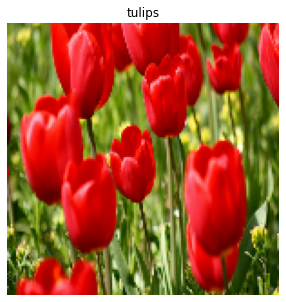

In [ ]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
        plt.imshow(images[0])
        plt.title(metadata.features['label'].int2str(labels[0]))
        plt.axis("off")

## 3. Image Agumentation
Now lets define some image agumentation and look at the mutated images

In [ ]:
# here we are randomly horizontally flipping the image/ randomly zooming into the image  
data_aug = tf.keras.Sequential([
                             tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                             tf.keras.layers.experimental.preprocessing.RandomZoom(0.5),
                             ])

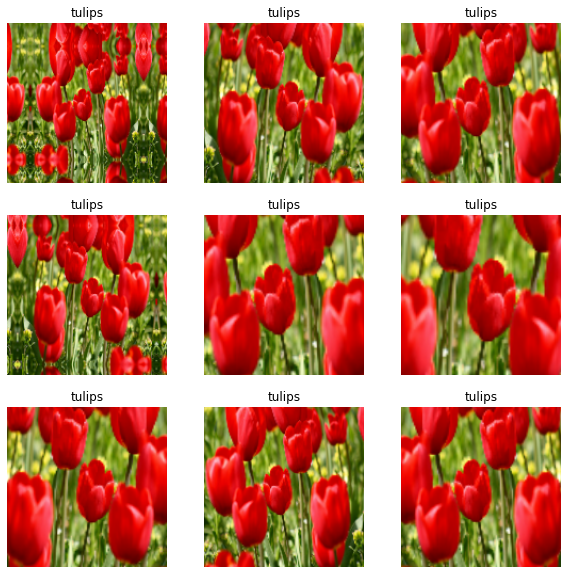

In [ ]:
# Lets take a look at a few agumented images
plt.figure(figsize=(10, 10))

for images,labels  in train_ds.take(1):
    for i in range(9):
        augmented_images = data_aug(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0])
        # 
        plt.title(metadata.features['label'].int2str(labels[0]))
        #print()
        plt.axis("off")

In [ ]:
  # From trainds create a agumented Dataset for experiments
  aug_train_ds = train_ds.map(lambda x, y: (data_aug(x, training=True), y),)

## A couple of more plots before and after agumentation

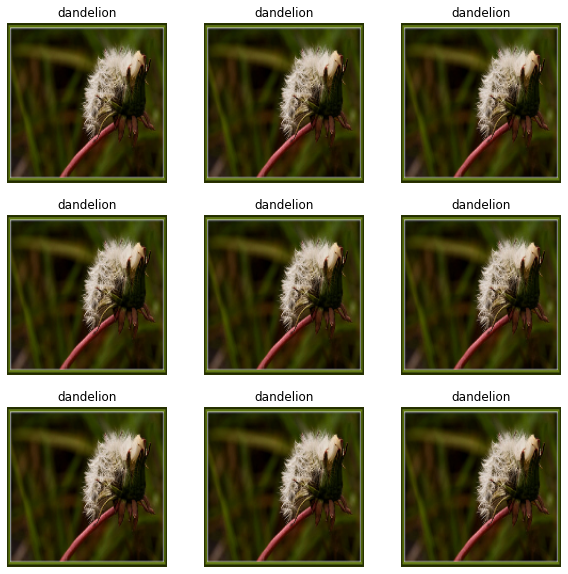

In [ ]:
# Before agumentation
plt.figure(figsize=(10, 10))

for images,labels  in train_ds.skip(2).take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[0])
        # 
        plt.title(metadata.features['label'].int2str(labels[0]))
        #print()
        plt.axis("off")

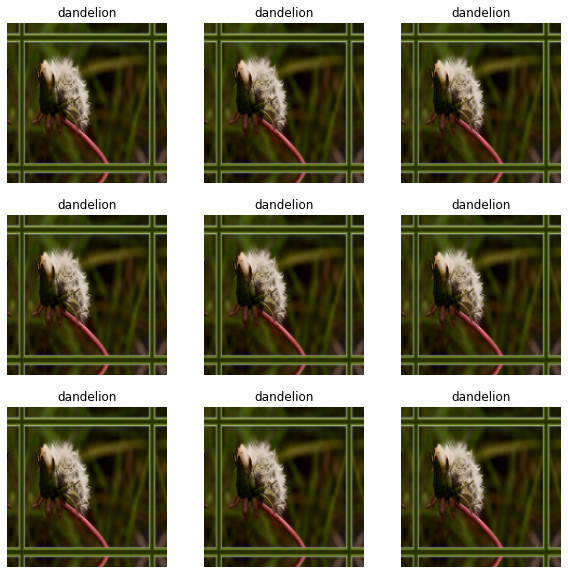

In [ ]:
# After agumentation

plt.figure(figsize=(10, 10))

for images,labels  in aug_train_ds.skip(2).take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[0])
        # 
        plt.title(metadata.features['label'].int2str(labels[0]))
        #print()
        plt.axis("off")

## 4. CNN model for image classification

In [ ]:
## A simple CNN based model
def create_cnn_model():
  model = tf.keras.Sequential([
                # Input image size is 150, 150, 3
                tf.keras.layers.Conv2D(16, (2,2), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
                tf.keras.layers.MaxPool2D(2,2),
                tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
                tf.keras.layers.MaxPool2D(2,2),
                tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
                tf.keras.layers.MaxPool2D(2,2),
                tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
                tf.keras.layers.MaxPool2D(2, 2),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(512, activation='relu'),
                # We have 5 classes of flowers
                tf.keras.layers.Dense(5, activation='softmax')
])
  model.compile(loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'],
                      optimizer='adam'
                      )
  return model


In [ ]:
# Use the agumented dataset
non_agumented_model = create_cnn_model()
agumented_model = create_cnn_model()


In [ ]:
# Early Stopping callback
ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights='True'
)


In [ ]:
non_agumented_model.fit(train_ds, #train_ds,
          epochs=10,
          validation_data=val_ds,
          callbacks=[ES]
          )

Epoch 1/10
92/92 [==============================] - 3s 25ms/step - loss: 1.2837 - accuracy: 0.4397 - val_loss: 1.0931 - val_accuracy: 0.5150
Epoch 2/10
92/92 [==============================] - 2s 24ms/step - loss: 0.9874 - accuracy: 0.6087 - val_loss: 0.9299 - val_accuracy: 0.6403
Epoch 3/10
92/92 [==============================] - 2s 24ms/step - loss: 0.8563 - accuracy: 0.6696 - val_loss: 0.8919 - val_accuracy: 0.6512
Epoch 4/10
92/92 [==============================] - 2s 23ms/step - loss: 0.7417 - accuracy: 0.7176 - val_loss: 0.8900 - val_accuracy: 0.6567
Epoch 5/10
92/92 [==============================] - 2s 23ms/step - loss: 0.6271 - accuracy: 0.7623 - val_loss: 0.8566 - val_accuracy: 0.6730
Epoch 6/10
92/92 [==============================] - 2s 23ms/step - loss: 0.5015 - accuracy: 0.8076 - val_loss: 0.8917 - val_accuracy: 0.6975
Epoch 7/10
92/92 [==============================] - 2s 22ms/step - loss: 0.4211 - accuracy: 0.8450 - val_loss: 0.8659 - val_accuracy: 0.6866
Epoch 8/10
92

In [ ]:
non_agumented_model.evaluate(test_ds)

12/12 [==============================] - 1s 53ms/step - loss: 0.7994 - accuracy: 0.7030


[0.7993828654289246, 0.7029972672462463]

In [ ]:
agumented_model.fit(aug_train_ds, #train_ds,
          epochs=10,
          validation_data=val_ds,
          callbacks=[ES]
          )

Epoch 1/10
92/92 [==============================] - 11s 115ms/step - loss: 1.3560 - accuracy: 0.4121 - val_loss: 1.0919 - val_accuracy: 0.5531
Epoch 2/10
92/92 [==============================] - 11s 115ms/step - loss: 1.0291 - accuracy: 0.5845 - val_loss: 0.9801 - val_accuracy: 0.6049
Epoch 3/10
92/92 [==============================] - 10s 112ms/step - loss: 0.9319 - accuracy: 0.6284 - val_loss: 0.8823 - val_accuracy: 0.6594
Epoch 4/10
92/92 [==============================] - 10s 111ms/step - loss: 0.8764 - accuracy: 0.6478 - val_loss: 0.8137 - val_accuracy: 0.6757
Epoch 5/10
92/92 [==============================] - 10s 111ms/step - loss: 0.8321 - accuracy: 0.6635 - val_loss: 0.8264 - val_accuracy: 0.6512
Epoch 6/10
92/92 [==============================] - 10s 113ms/step - loss: 0.7834 - accuracy: 0.6914 - val_loss: 0.7958 - val_accuracy: 0.6757
Epoch 7/10
92/92 [==============================] - 11s 115ms/step - loss: 0.7323 - accuracy: 0.7166 - val_loss: 0.7517 - val_accuracy: 0.7003

In [ ]:
agumented_model.evaluate(test_ds)

12/12 [==============================] - 0s 17ms/step - loss: 0.6343 - accuracy: 0.7575


[0.6342950463294983, 0.7574931979179382]